## Projeto
Classificação binária - Real ou Deepfake.

---

Link do desafio no Kaggle:
https://www.kaggle.com/competitions/image-classification-real-or-ai-generated-photo/data

In [65]:
import os
import pandas as pd

### Open and investigate Dataset

In [66]:
from pathlib import Path
notebook_path = Path().resolve()

dataset_base_path = notebook_path.parent / "dataset/"

train_path = dataset_base_path / "train/train"
test_path = dataset_base_path / "test/test"

train_images = sorted(os.listdir(train_path), key=lambda x: int(os.path.splitext(x)[0]))
test_images = sorted(os.listdir(test_path), key=lambda x: int(os.path.splitext(x)[0]))

train_labels = pd.read_csv(dataset_base_path / "train.csv")
test_labels = pd.read_csv(dataset_base_path / "test.csv")

In [67]:
from PIL import Image
import matplotlib.pyplot as plt
import random

In [68]:
def print_images(images, label, total_images = 6):
    sample_images = random.sample(images, total_images)
    
    fig, axes = plt.subplots(1, total_images, figsize=(12, 2))
    fig.suptitle(label, fontsize=16)
    for ax, img_name in zip(axes.flatten(), sample_images):
        img = Image.open(train_path / img_name)
        ax.imshow(img)
        ax.set_title(img_name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
label_real_images = 1
label_ai_generated = 0

real_train_images = train_labels[train_labels['Label'] == label_real_images]['Image'].tolist()
fake_train_images = train_labels[train_labels['Label'] == label_ai_generated]['Image'].tolist()

print_images(images=real_train_images, label="Real")
print_images(images=fake_train_images, label="Ai-Gen")

In [ ]:
print("Check class balacing")
print(train_labels['Label'].value_counts().to_dict())

print()
print(f"Train samples: {len(train_images)}")
print(f"Test samples: {len(test_images)}")

print()
print("Sample of Labels Table")
print(train_labels.head())

Check class balacing
{1: 478, 0: 467}

Total for train: 945
Total for test: 402

Sample of Labels Table
   Image  Label
0  1.jpg      0
1  2.jpg      0
2  3.jpg      1
3  4.jpg      1
4  5.jpg      0


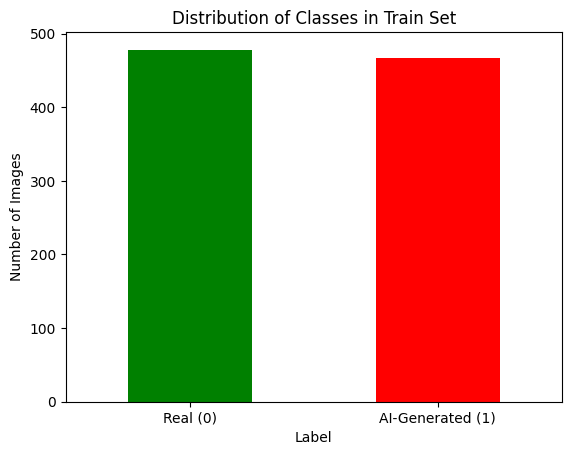

In [86]:
train_labels['Label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Distribution of Classes in Train Set")
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.xticks([0,1], ['Real (0)', 'AI-Generated (1)'], rotation=0)
plt.show()

#### Pre-processamento

In [ ]:
# Dividir em treino e validação (teste esta separado)

In [ ]:
# (pré-processamento, normalização, validação, modelagem, comparação).